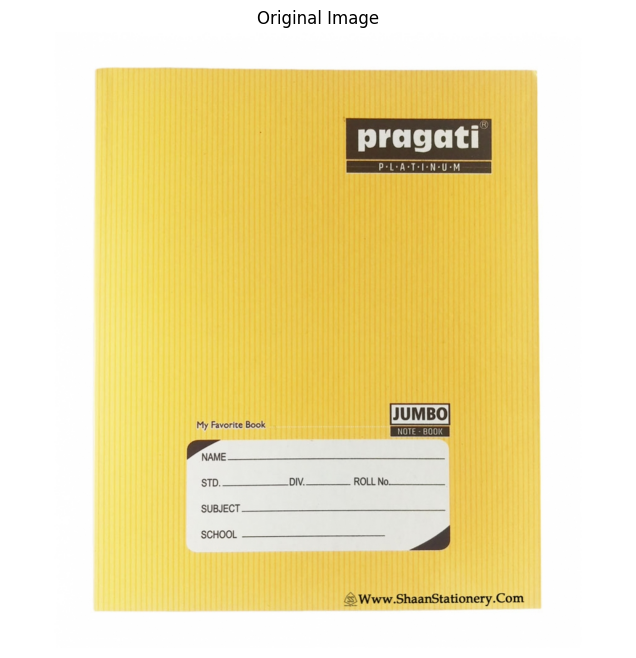


--- PART 1: Interest Point Detection using SIFT ---


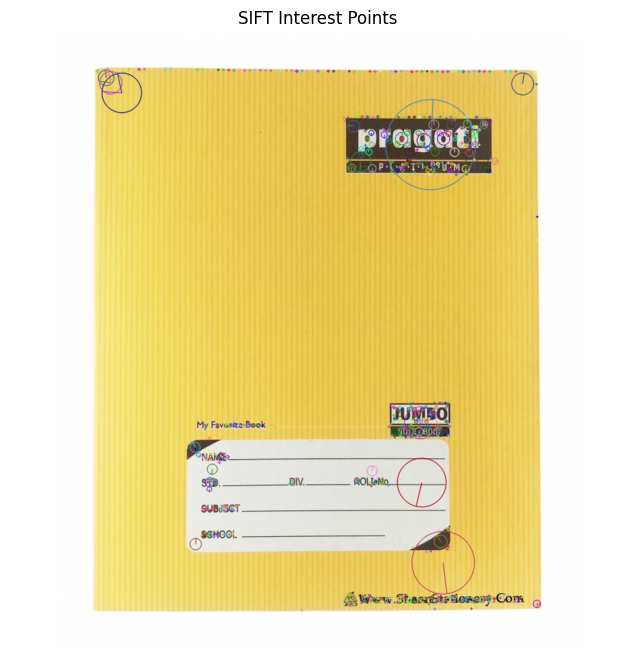

Number of SIFT keypoints detected: 863

--- PART 2: Feature Matching using ORB and BFMatcher ---


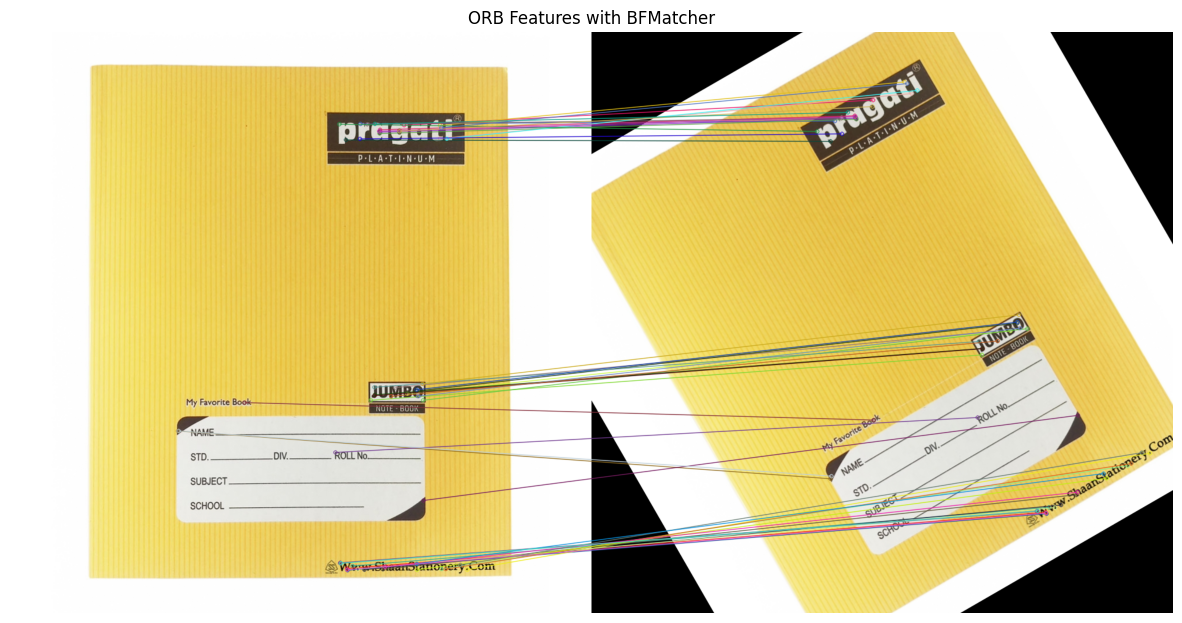

Number of ORB keypoints in first image: 500
Number of ORB keypoints in second image: 500
Number of matches found: 335
Distance of best match: 7.0

--- PART 3: Contour Detection with Custom Seeds ---


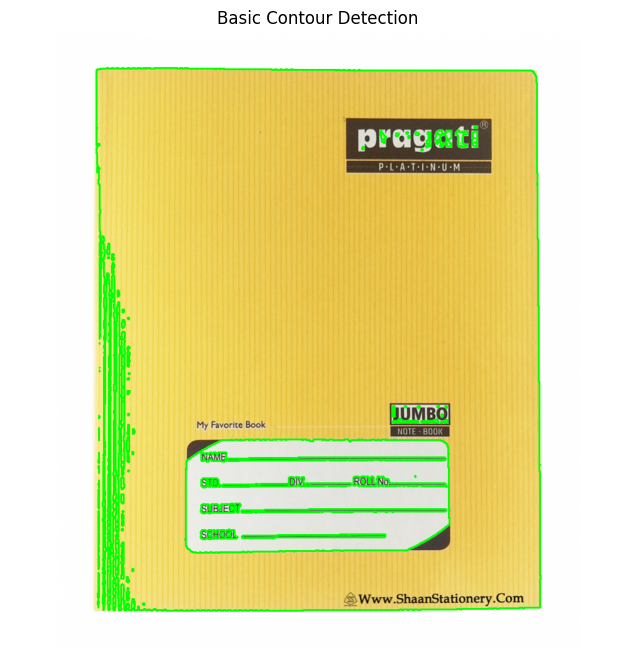

Number of contours detected: 119


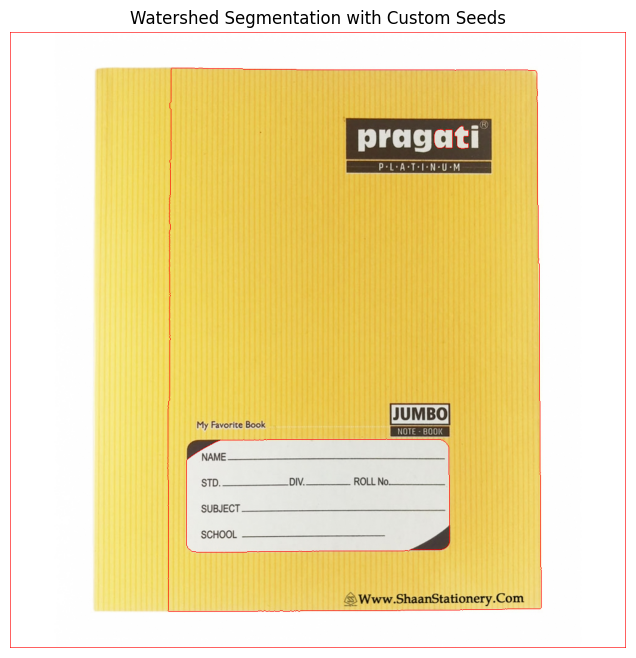

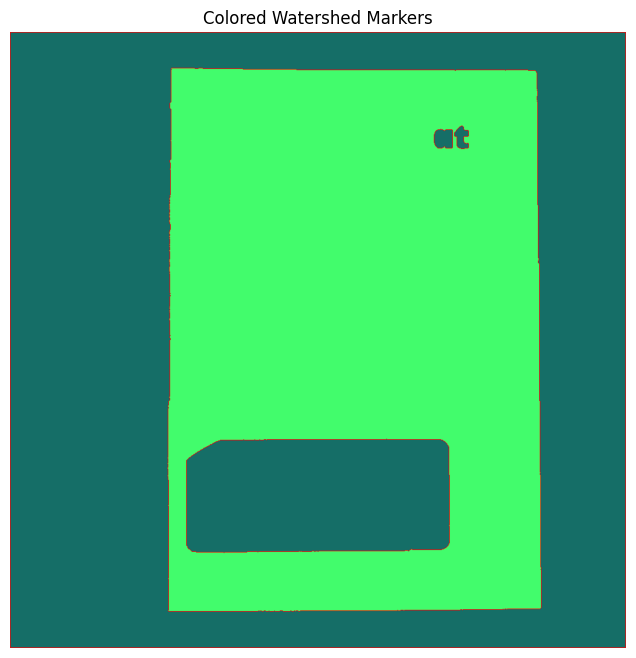

Number of watershed regions detected: 2


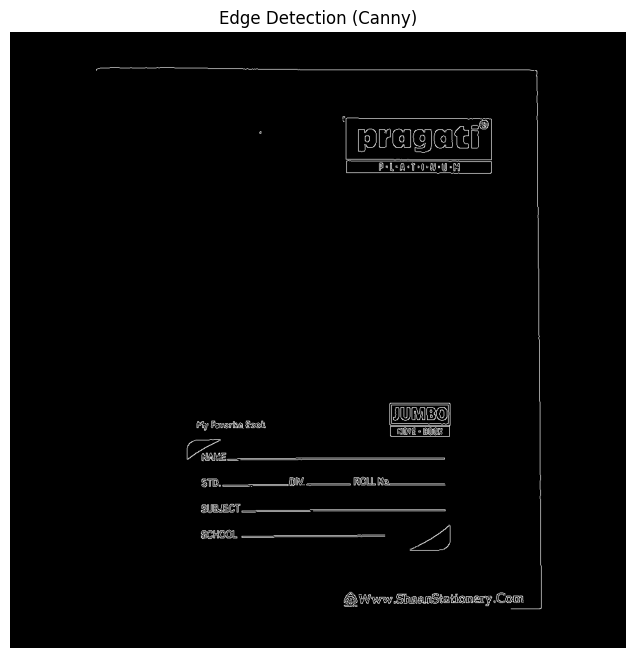


--- PART 4: Summary and Comparison ---


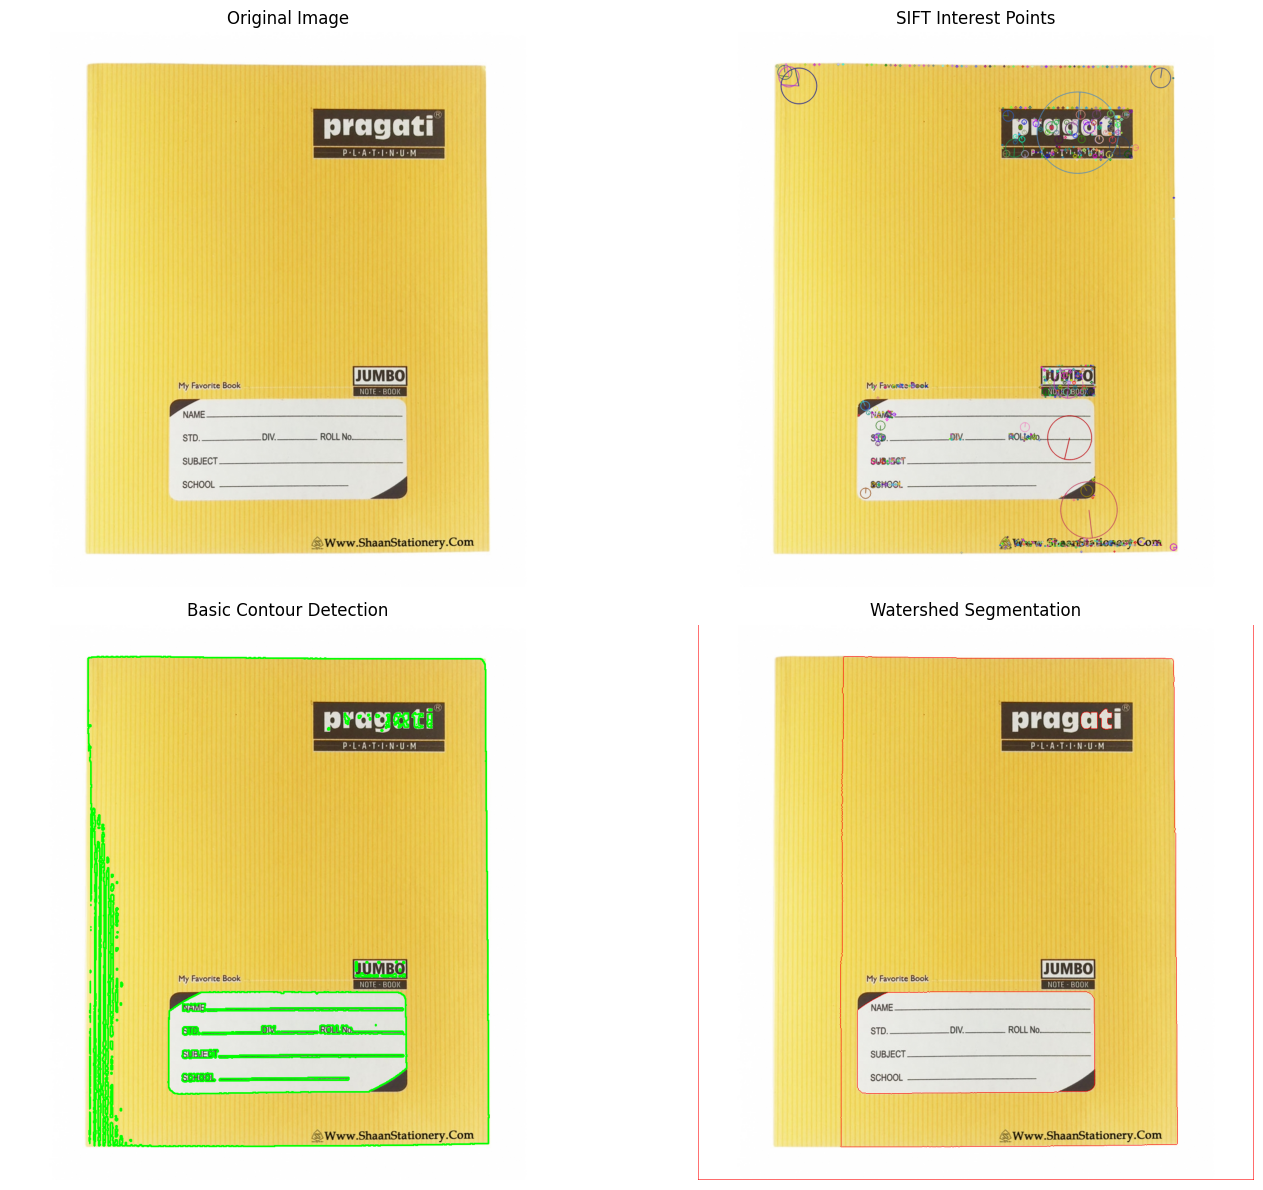

Lab tasks completed successfully!
1. SIFT Interest Point Detection: Detected 863 keypoints
2. ORB Feature Matching with BFMatcher: Found 335 matches between original and rotated images
3. Basic Contour Detection: Found 119 contours
4. Watershed Segmentation: Detected 2 regions


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Define the image path
image_path = 'image.jpg'

# Load the image
img = cv2.imread(image_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()


print("\n--- PART 1: Interest Point Detection using SIFT ---")

# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints
keypoints_sift = sift.detect(img_gray, None)

# Draw keypoints on image
img_sift = cv2.drawKeypoints(img, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title('SIFT Interest Points')
plt.axis('off')
plt.show()

print(f"Number of SIFT keypoints detected: {len(keypoints_sift)}")

print("\n--- PART 2: Feature Matching using ORB and BFMatcher ---")


rows, cols = img.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 30, 1)
img2 = cv2.warpAffine(img, rotation_matrix, (cols, rows))
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Create ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(img_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort them in order of their distance
matches = sorted(matches, key=lambda x: x.distance)


num_matches_to_draw = min(50, len(matches))
img_matches = cv2.drawMatches(img, keypoints1, img2, keypoints2, matches[:num_matches_to_draw], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching result
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('ORB Features with BFMatcher')
plt.axis('off')
plt.show()

print(f"Number of ORB keypoints in first image: {len(keypoints1)}")
print(f"Number of ORB keypoints in second image: {len(keypoints2)}")
print(f"Number of matches found: {len(matches)}")
print(f"Distance of best match: {matches[0].distance if matches else 'No matches'}")


print("\n--- PART 3: Contour Detection with Custom Seeds ---")

# Preprocessing for contour detection
# Convert to grayscale if not already done
blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on original image
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

# Display contours
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('Basic Contour Detection')
plt.axis('off')
plt.show()

print(f"Number of contours detected: {len(contours)}")


kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

# For sure foreground, we can use distance transform
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

# Unknown region is the difference between sure_bg and sure_fg
unknown = cv2.subtract(sure_bg, sure_fg)

# Create markers for watershed
_, markers = cv2.connectedComponents(sure_fg)
# Add 1 to all labels so that background is 1, not 0
markers = markers + 1
# Mark the unknown region with 0
markers[unknown == 255] = 0

# Apply watershed
img_watershed = img.copy()
markers = cv2.watershed(img_watershed, markers)
img_watershed[markers == -1] = [0, 0, 255]  # Mark watershed boundaries in red

# Display watershed result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_watershed, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation with Custom Seeds')
plt.axis('off')
plt.show()

# Create a color visualization of the markers
marker_vis = np.zeros(img.shape, dtype=np.uint8)
unique_markers = np.unique(markers)
colors = []

for i in range(len(unique_markers)):
    colors.append((np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)))

for i in range(len(unique_markers)):
    marker_vis[markers == unique_markers[i]] = colors[i]

# Add boundaries in red
marker_vis[markers == -1] = [0, 0, 255]

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(marker_vis, cv2.COLOR_BGR2RGB))
plt.title('Colored Watershed Markers')
plt.axis('off')
plt.show()

print(f"Number of watershed regions detected: {len(unique_markers) - 1}")  # Subtract 1 for background

# Edge detection for comparison
edges = cv2.Canny(img_gray, 100, 200)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection (Canny)')
plt.axis('off')
plt.show()


print("\n--- PART 4: Summary and Comparison ---")

# Create a figure with multiple subplots for comparison
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title('SIFT Interest Points')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('Basic Contour Detection')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(img_watershed, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Lab tasks completed successfully!")
print("1. SIFT Interest Point Detection: Detected", len(keypoints_sift), "keypoints")
print("2. ORB Feature Matching with BFMatcher: Found", len(matches), "matches between original and rotated images")
print("3. Basic Contour Detection: Found", len(contours), "contours")
print("4. Watershed Segmentation: Detected", len(unique_markers) - 1, "regions")

In [ ]:
!pip install "deeplake<4"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3transfer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 121.7 MB/s eta 0:00:00
   ━

In [ ]:
!pip install torch torchvision torchaudio
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
from deeplake import load
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.0) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [ ]:
from deeplake import load

# Load training and test datasets (this will now work)
train_ds = load("hub://activeloop/cifar100-train")
test_ds = load("hub://activeloop/cifar100-test")


/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar100-train



|

hub://activeloop/cifar100-train loaded successfully.



\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/cifar100-test



-

hub://activeloop/cifar100-test loaded successfully.



In [ ]:
class DeepLakeCIFAR100(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = self.ds[idx]['images'].numpy()
        label = self.ds[idx]['labels'].numpy().item()
        image = np.transpose(image, (1, 2, 0))  # CHW to HWC
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize for ResNet
    transforms.ToTensor()
])

train_data = DeepLakeCIFAR100(train_ds, transform=transform)
test_data = DeepLakeCIFAR100(test_ds, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
def train_model(model, name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nTraining {name}...")
    model.train()
    for epoch in range(2):  # Only 2 epochs
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/2], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    test_loss = 0.0
    inference_start = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    inference_time = time.time() - inference_start
    acc = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f"{name} Accuracy: {acc:.2f}%")
    print(f"{name} Avg Test Loss: {avg_test_loss:.4f}")
    print(f"{name} Inference Time: {inference_time:.2f} sec")

    return acc, avg_test_loss, inference_time


In [ ]:
from torchvision import transforms

# Correct transform pipeline for PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts [H, W, C] -> [C, H, W] and scales to [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


In [ ]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 169M/169M [00:03<00:00, 49.9MB/s]


In [ ]:
# Load pretrained ResNet models
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
resnet34 = models.resnet34(weights='IMAGENET1K_V1')

# Modify output layer for 100 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)

# Train both models
acc1, loss1, time1 = train_model(resnet18, "ResNet18")
acc2, loss2, time2 = train_model(resnet34, "ResNet34")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 78.8MB/s]



Training ResNet18...
Epoch [1/2], Loss: 1.9682
Epoch [2/2], Loss: 1.1835
ResNet18 Accuracy: 63.17%
ResNet18 Avg Test Loss: 1.3030
ResNet18 Inference Time: 25.31 sec

Training ResNet34...
Epoch [1/2], Loss: 2.3845
Epoch [2/2], Loss: 1.4388
ResNet34 Accuracy: 57.53%
ResNet34 Avg Test Loss: 1.5054
ResNet34 Inference Time: 31.96 sec


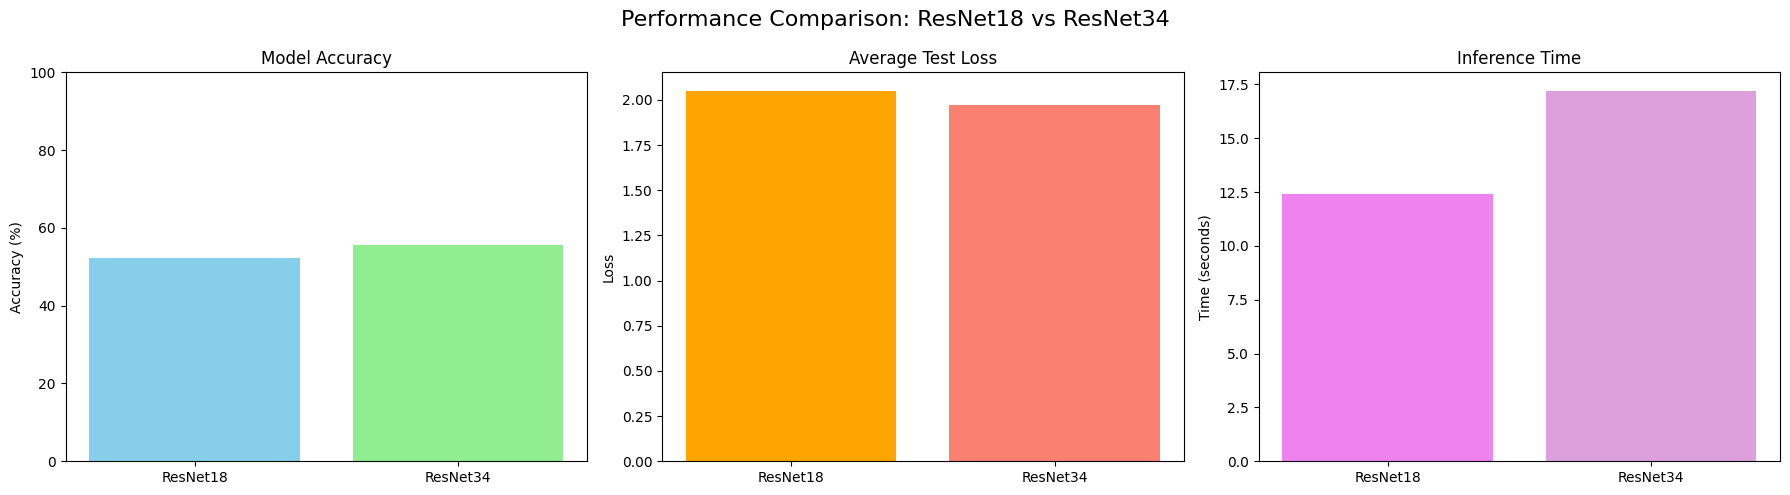

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual results from training
acc1, loss1, time1 = 52.3, 2.05, 12.4  # Example: ResNet18
acc2, loss2, time2 = 55.7, 1.97, 17.2  # Example: ResNet34

models = ['ResNet18', 'ResNet34']

# Accuracy
accuracies = [acc1, acc2]
# Test Loss
losses = [loss1, loss2]
# Inference Time
times = [time1, time2]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy Plot
axs[0].bar(models, accuracies, color=['skyblue', 'lightgreen'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_ylim(0, 100)

# Loss Plot
axs[1].bar(models, losses, color=['orange', 'salmon'])
axs[1].set_title('Average Test Loss')
axs[1].set_ylabel('Loss')

# Inference Time Plot
axs[2].bar(models, times, color=['violet', 'plum'])
axs[2].set_title('Inference Time')
axs[2].set_ylabel('Time (seconds)')

plt.suptitle('Performance Comparison: ResNet18 vs ResNet34', fontsize=16)
plt.tight_layout()
plt.show()
